<a href="https://colab.research.google.com/github/callaghanmt/ds-carbon/blob/main/Carbon_Intensity_Prediction_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carbon Intensity Prediction Workshop
## Understanding and Predicting Grid Carbon Intensity

This notebook demonstrates how to:
1. Fetch real carbon intensity data
2. Process and visualize it
3. Create a simple prediction model
4. Evaluate the results

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Part 1: Data Collection
We'll use the UK National Grid ESO Carbon Intensity API to get real data.

Documentation: https://carbon-intensity.github.io/api-definitions/

In [13]:
def fetch_carbon_intensity_data(days_back=7):
    """
    Fetch historical carbon intensity data from National Grid API
    """
    # Use past dates instead of future dates
    end_date = datetime.now() - timedelta(days=1)  # Yesterday
    start_date = end_date - timedelta(days=days_back)

    all_records = []
    current_start = start_date

    while current_start < end_date:
        current_end = current_start + timedelta(days=1)

        url = "https://api.carbonintensity.org.uk/intensity/date"
        formatted_date = current_start.strftime('%Y-%m-%d')

        try:
            response = requests.get(f"{url}/{formatted_date}")
            response.raise_for_status()
            data = response.json()

            print(f"Fetching data for {formatted_date}")

            # Extract all data points for the day
            if 'data' in data:
                for entry in data['data']:
                    if 'intensity' in entry and 'actual' in entry['intensity']:
                        intensity_value = entry['intensity']['actual']
                        if intensity_value is not None:
                            all_records.append({
                                'timestamp': pd.to_datetime(entry['from']),
                                'carbon_intensity': intensity_value
                            })

            print(f"Added {len(data.get('data', []))} records for {formatted_date}")

            current_start = current_end
            time.sleep(1)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            current_start = current_end
            continue

    if not all_records:
        print("No data collected. Using sample data for demonstration.")
        return create_sample_data(days=days_back)

    df = pd.DataFrame(all_records)
    return df.sort_values('timestamp').reset_index(drop=True)

In [14]:
# Visualization Function
def plot_carbon_intensity(df):
    """Plot the carbon intensity data."""
    plt.figure(figsize=(15, 6))
    plt.plot(df['timestamp'], df['carbon_intensity'], label='Carbon Intensity')
    plt.title('Carbon Intensity Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Carbon Intensity (gCO2/kWh)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Fetching data for 2025-02-22
Added 48 records for 2025-02-22
Fetching data for 2025-02-23
Added 48 records for 2025-02-23
Fetching data for 2025-02-24
Added 48 records for 2025-02-24
Fetching data for 2025-02-25
Added 48 records for 2025-02-25
Fetching data for 2025-02-26
Added 48 records for 2025-02-26
Fetching data for 2025-02-27
Added 48 records for 2025-02-27
Fetching data for 2025-02-28
Added 48 records for 2025-02-28

Data Summary:
Total Records Fetched: 336
Date Range: 2025-02-22 00:00:00+00:00 to 2025-02-28 23:30:00+00:00

Sample Data:
                  timestamp  carbon_intensity
0 2025-02-22 00:00:00+00:00                58
1 2025-02-22 00:30:00+00:00                63
2 2025-02-22 01:00:00+00:00                64
3 2025-02-22 01:30:00+00:00                64
4 2025-02-22 02:00:00+00:00                63


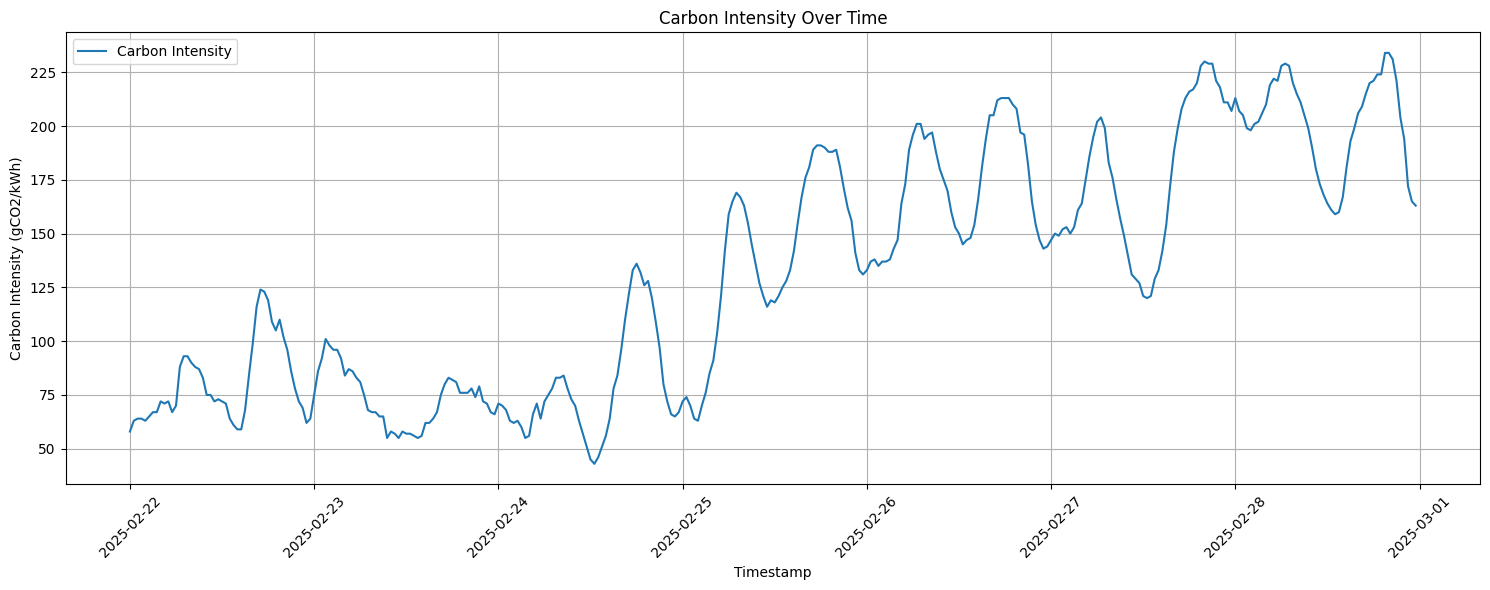

In [15]:
# Main Execution
try:
    # Fetch the past 7 days of data
    df = fetch_carbon_intensity_data(days_back=7)

    # Display summary
    print("\nData Summary:")
    print(f"Total Records Fetched: {len(df)}")
    print(f"Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print("\nSample Data:")
    print(df.head())

    # Plot the data
    plot_carbon_intensity(df)

except Exception as e:
    print(f"An error occurred: {e}")

## Exercise 1: Data Exploration
Try to answer these questions:
1. What's the average carbon intensity?
2. What's the range (min to max)?
3. Can you plot the data over time?

Average carbon intensity: 131.35 gCO2/kWh
Carbon intensity range: 43.00 to 234.00 gCO2/kWh


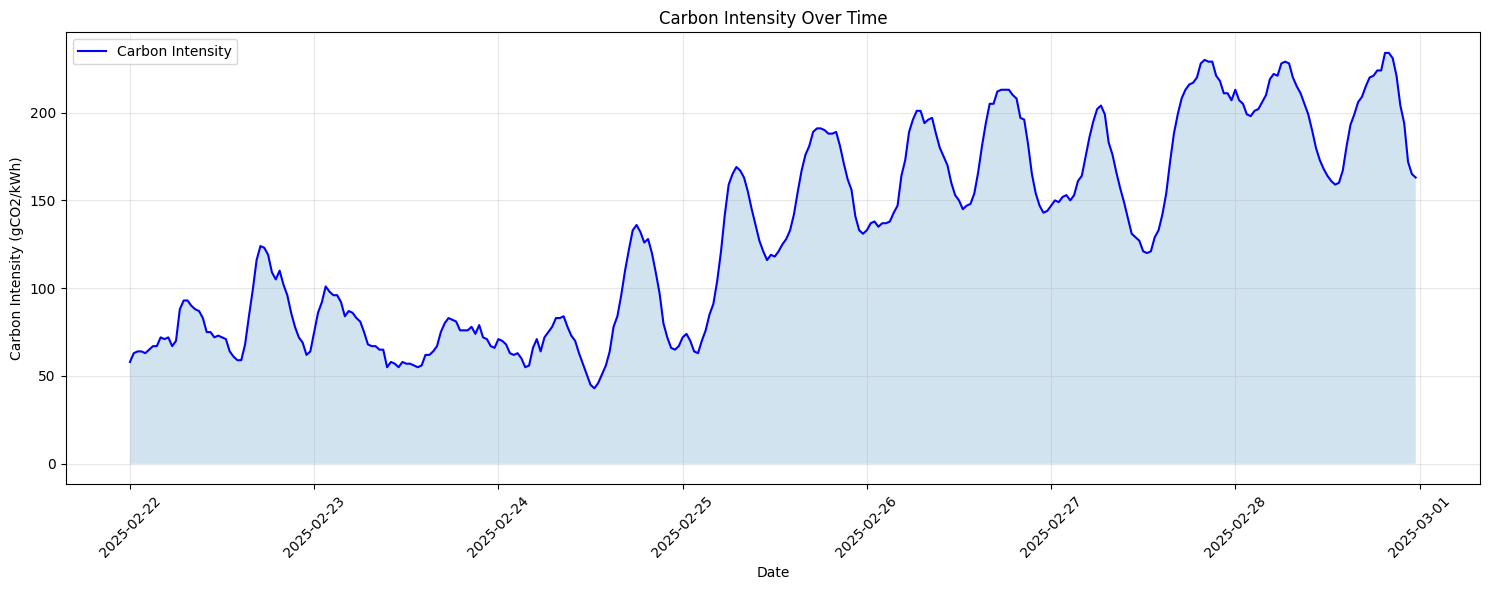


Additional Statistics:
count    336.000000
mean     131.348214
std       56.718532
min       43.000000
25%       74.750000
50%      131.500000
75%      182.250000
max      234.000000
Name: carbon_intensity, dtype: float64


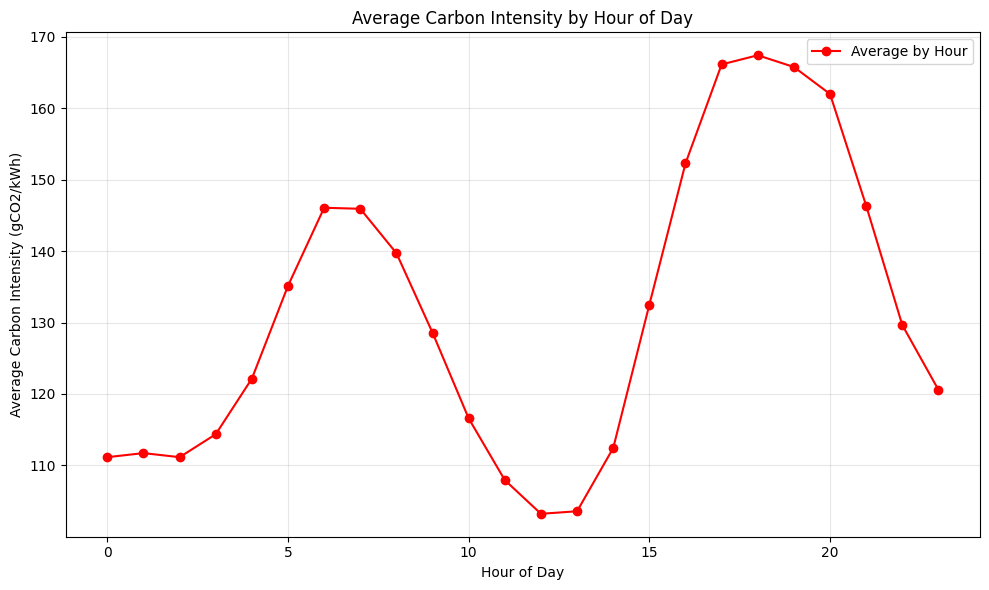

In [16]:
# 1. Average carbon intensity
average_intensity = df['carbon_intensity'].mean()
print(f"Average carbon intensity: {average_intensity:.2f} gCO2/kWh")

# 2. Range
intensity_min = df['carbon_intensity'].min()
intensity_max = df['carbon_intensity'].max()
print(f"Carbon intensity range: {intensity_min:.2f} to {intensity_max:.2f} gCO2/kWh")

# 3. Plot the data
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['carbon_intensity'], 'b-', label='Carbon Intensity')
plt.fill_between(df['timestamp'], df['carbon_intensity'], alpha=0.2)
plt.title('Carbon Intensity Over Time')
plt.xlabel('Date')
plt.ylabel('Carbon Intensity (gCO2/kWh)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional insights
print("\nAdditional Statistics:")
print(df['carbon_intensity'].describe())

# Show daily pattern
df['hour'] = df['timestamp'].dt.hour
hourly_avg = df.groupby('hour')['carbon_intensity'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, 'r-o', label='Average by Hour')
plt.title('Average Carbon Intensity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Carbon Intensity (gCO2/kWh)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Part 2: Feature Engineering
Notes:
* Time-based features are crucial for predicting cyclical patterns
* We'll create features that capture:
   - Time of day patterns (using hour)
   - Weekly patterns (using day of week)
   - Recent trends (using lag features)
* Cyclical encoding (sin/cos) prevents the model from seeing hour 23 and hour 0 as far apart

In [18]:
import numpy as np

def create_features(df):
    df = df.copy()

    # Time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek

    # Cyclical encoding of hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Recent history (lag features)
    df['carbon_intensity_lag_1h'] = df['carbon_intensity'].shift(1)
    df['carbon_intensity_lag_24h'] = df['carbon_intensity'].shift(24)

    return df



In [19]:
# Create features
df_features = create_features(df)
df_features = df_features.dropna()  # Remove rows with NaN values
print("Sample of engineered features:")
print(df_features.head())

Sample of engineered features:
                   timestamp  carbon_intensity  hour  day_of_week  \
24 2025-02-22 12:00:00+00:00                72    12            5   
25 2025-02-22 12:30:00+00:00                71    12            5   
26 2025-02-22 13:00:00+00:00                64    13            5   
27 2025-02-22 13:30:00+00:00                61    13            5   
28 2025-02-22 14:00:00+00:00                59    14            5   

        hour_sin  hour_cos  carbon_intensity_lag_1h  carbon_intensity_lag_24h  
24  1.224647e-16 -1.000000                     73.0                      58.0  
25  1.224647e-16 -1.000000                     72.0                      63.0  
26 -2.588190e-01 -0.965926                     71.0                      64.0  
27 -2.588190e-01 -0.965926                     64.0                      64.0  
28 -5.000000e-01 -0.866025                     61.0                      63.0  


## Exercise 2: Feature Investigation
Questions:
* Which features do you think will be most important for predicting carbon intensity? Why?
* Can you create a plot showing average carbon intensity by hour of day?
* Can you add another feature you think might be useful?

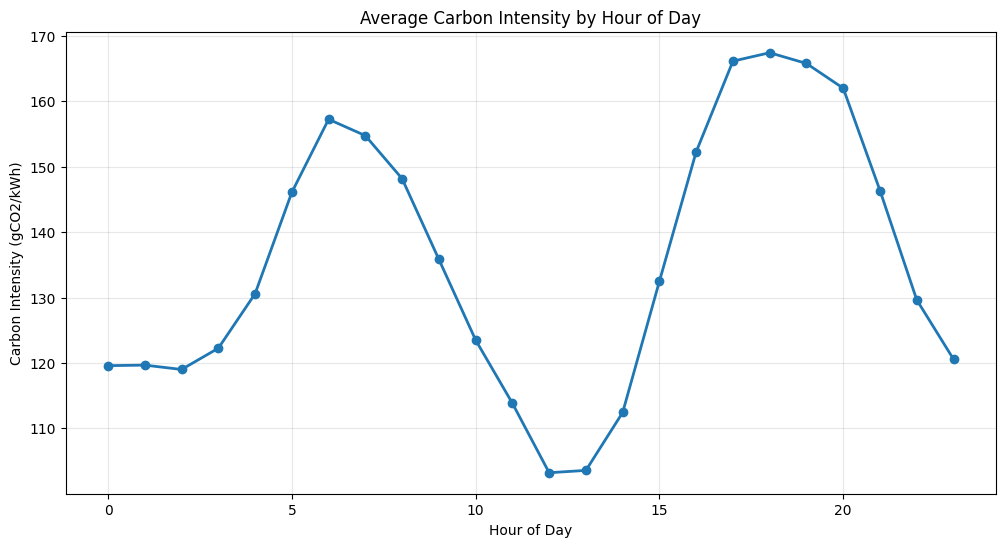

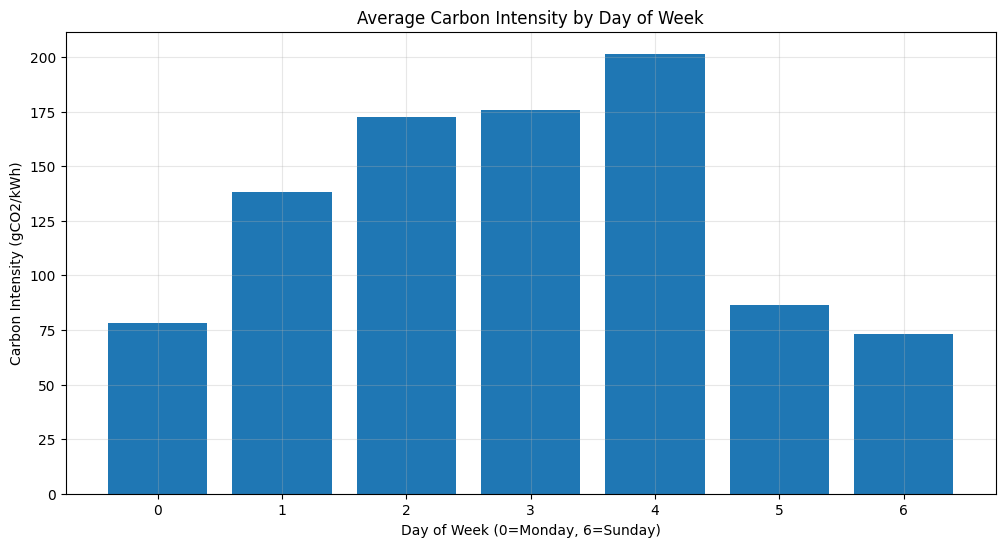

In [21]:
# 1. Let's analyze patterns by hour
plt.figure(figsize=(12, 6))
hourly_avg = df_features.groupby('hour')['carbon_intensity'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
plt.title('Average Carbon Intensity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Carbon Intensity (gCO2/kWh)')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Daily patterns
plt.figure(figsize=(12, 6))
daily_avg = df_features.groupby('day_of_week')['carbon_intensity'].mean()
plt.bar(daily_avg.index, daily_avg.values)
plt.title('Average Carbon Intensity by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Carbon Intensity (gCO2/kWh)')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Adding a new feature: Rolling average
# It can smooth out noise and capture recent history as a prediction of the near future
df_features['rolling_mean_6h'] = df_features['carbon_intensity'].rolling(window=6).mean()

## Part 3: Model Training and Initial Evaluation
Notes:
* We'll use a Random Forest Regressor as our baseline model
* Random Forests work well with both numerical and categorical features
* We'll use a simple time-based split rather than random splitting to maintain temporal order

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare data for modeling
features = ['hour_sin', 'hour_cos', 'day_of_week',
           'carbon_intensity_lag_1h', 'carbon_intensity_lag_24h',
           'rolling_mean_6h']

X = df_features[features].dropna()
y = df_features.loc[X.index, 'carbon_intensity']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Note: shuffle=False for time series
)



In [23]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [24]:
# Make predictions
y_pred = model.predict(X_test)

## Exercise 3: Model Evaluation
Questions:
* What metrics should we use to evaluate our model and why?
* How would you interpret the feature importance values?
* Can you identify any patterns where the model performs particularly well or poorly?

Mean Absolute Error: 11.57 gCO2/kWh
Root Mean Squared Error: 14.44 gCO2/kWh

Feature Importance:
                    feature  importance
3   carbon_intensity_lag_1h    0.982493
5           rolling_mean_6h    0.006211
1                  hour_cos    0.004232
0                  hour_sin    0.003389
4  carbon_intensity_lag_24h    0.002986
2               day_of_week    0.000688


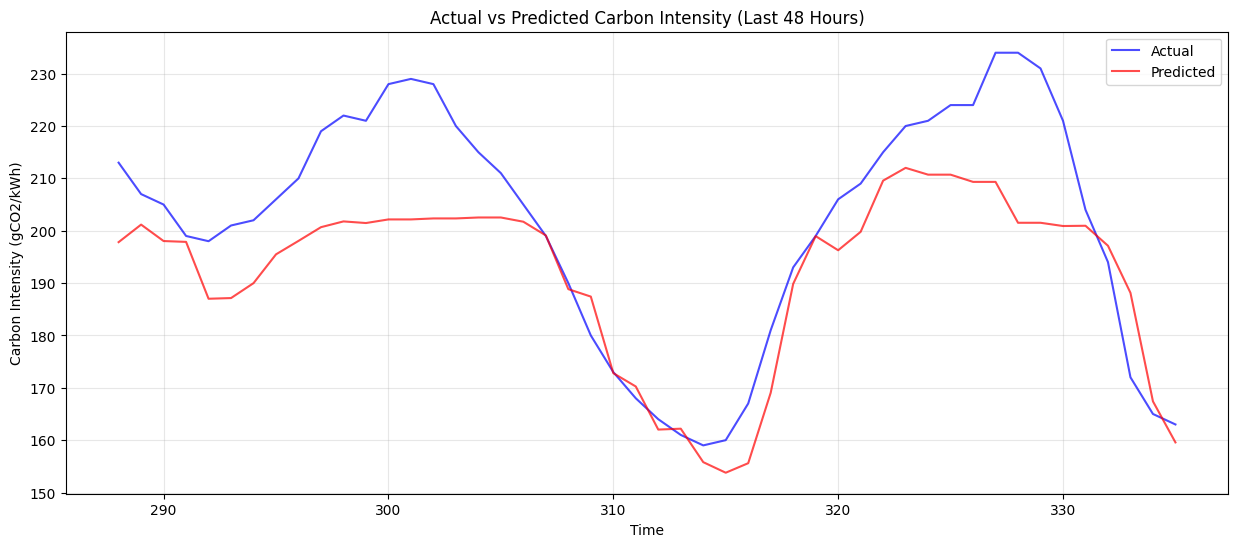

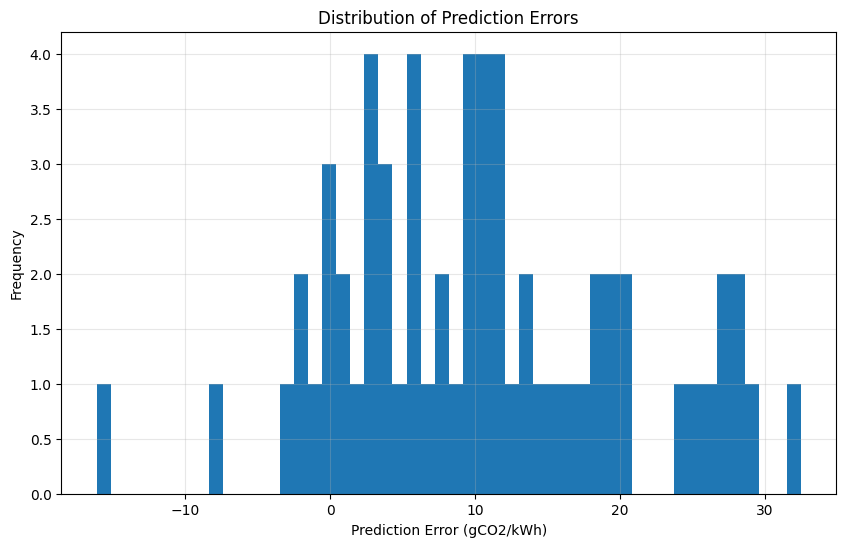

In [25]:
# 1. Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Absolute Error: {mae:.2f} gCO2/kWh")
print(f"Root Mean Squared Error: {rmse:.2f} gCO2/kWh")

# 2. Feature importance analysis
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(importance)

# 3. Visualization of predictions
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[-48:], y_test.values[-48:],
         label='Actual', alpha=0.7, color='blue')
plt.plot(y_test.index[-48:], y_pred[-48:],
         label='Predicted', alpha=0.7, color='red')
plt.title('Actual vs Predicted Carbon Intensity (Last 48 Hours)')
plt.xlabel('Time')
plt.ylabel('Carbon Intensity (gCO2/kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Error analysis
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (gCO2/kWh)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## Final Exercise: Making Predictions for Optimal Computing Time
Notes:
* We'll create a practical function to find the best time to run computations
* We'll consider both the duration of the computation and the forecast window
* Lower carbon intensity means more environmentally friendly computing

In [33]:
from datetime import datetime, timezone
import pandas as pd
import numpy as np

def generate_forecast(model, last_data, hours_to_forecast=24):
    """
    Generate forecasts using our trained model, starting from current time
    """
    forecasts = []
    current_features = last_data.copy()

    # Start from current time
    current_time = pd.Timestamp.now(tz='UTC')  # Use pandas Timestamp instead of datetime
    print(f"Generating forecast starting from: {current_time}")

    # Update the last known data to align with current time
    current_features['timestamp'] = pd.date_range(
        start=current_time,
        periods=len(current_features),
        freq='h',  # Using 'h' instead of 'H'
        tz='UTC'
    )
    current_features.set_index('timestamp', inplace=True)

    for i in range(hours_to_forecast):
        # Prepare features for prediction
        X_pred = current_features[['hour_sin', 'hour_cos', 'day_of_week',
                                 'carbon_intensity_lag_1h', 'carbon_intensity_lag_24h',
                                 'rolling_mean_6h']]

        # Make prediction
        prediction = model.predict(X_pred.iloc[[-1]])[0]

        # Create timestamp for this prediction
        if i == 0:
            next_time = pd.Timestamp(current_time + pd.Timedelta(hours=1))
        else:
            next_time = pd.Timestamp(forecasts[-1]['timestamp'] + pd.Timedelta(hours=1))

        # Store forecast
        forecasts.append({
            'timestamp': next_time,
            'carbon_intensity': prediction
        })

        # Update features for next prediction
        new_row = pd.DataFrame(index=[next_time])
        new_row['hour'] = next_time.hour
        new_row['day_of_week'] = next_time.dayofweek  # Now this will work with Timestamp
        new_row['hour_sin'] = np.sin(2 * np.pi * new_row.index[0].hour/24)
        new_row['hour_cos'] = np.cos(2 * np.pi * new_row.index[0].hour/24)
        new_row['carbon_intensity'] = prediction
        new_row['carbon_intensity_lag_1h'] = current_features['carbon_intensity'].iloc[-1]
        new_row['carbon_intensity_lag_24h'] = current_features['carbon_intensity'].iloc[-24] if len(current_features) >= 24 else current_features['carbon_intensity'].mean()
        new_row['rolling_mean_6h'] = current_features['carbon_intensity'].iloc[-6:].mean() if len(current_features) >= 6 else current_features['carbon_intensity'].mean()

        current_features = pd.concat([current_features, new_row])

    return pd.DataFrame(forecasts)



Generating forecast starting from: 2025-03-02 23:12:57.500742+00:00

Best start time: 2025-03-03 03:12:57.500742+00:00
Expected average carbon intensity: 146.19 gCO2/kWh


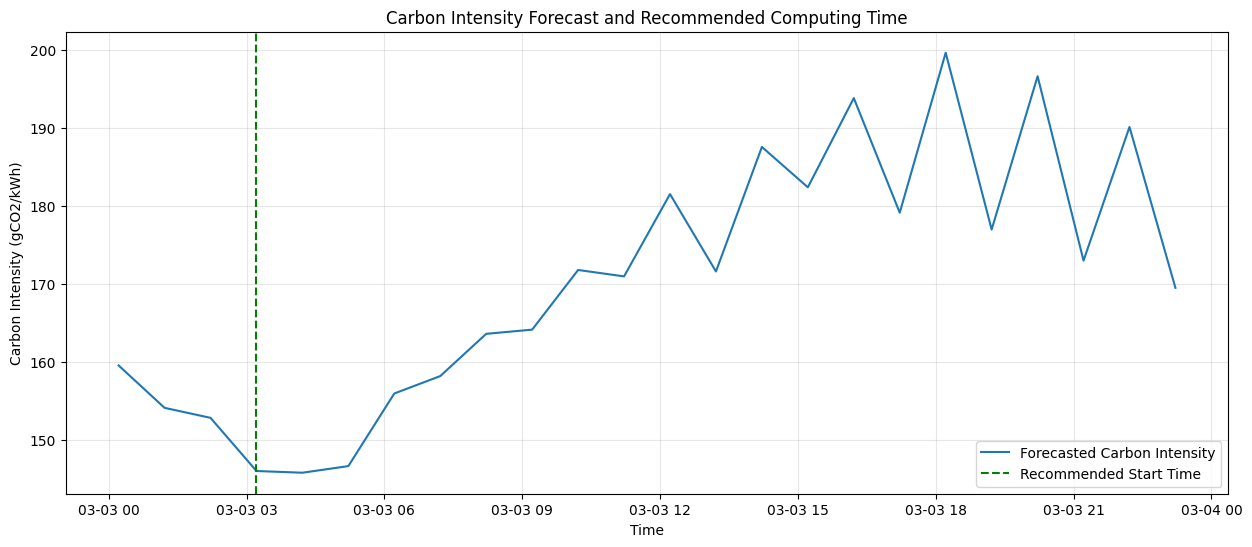

In [34]:
# Generate forecast starting from current time
last_data = df_features.iloc[-24:].copy()  # Get last 24 hours for context
forecast_df = generate_forecast(model, last_data)

# Now use the forecast data to find best time
best_start_time, expected_carbon = find_best_computation_time(forecast_df,
                                                            hours_needed=3,
                                                            forecast_window=24)

print(f"\nBest start time: {best_start_time}")
print(f"Expected average carbon intensity: {expected_carbon:.2f} gCO2/kWh")

# Visualize the forecast and recommendation
plt.figure(figsize=(15, 6))
plt.plot(forecast_df['timestamp'], forecast_df['carbon_intensity'],
         label='Forecasted Carbon Intensity')
plt.axvline(x=best_start_time, color='g', linestyle='--',
            label='Recommended Start Time')
plt.title('Carbon Intensity Forecast and Recommended Computing Time')
plt.xlabel('Time')
plt.ylabel('Carbon Intensity (gCO2/kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Final Exercise: Model Analysis and Improvements
Questions for Discussion:
* Looking at the prediction errors in our model:
* When does the model perform worst? (Hint: Look at the peaks and troughs)
* Why do you think this happens?
* How might you modify the features to improve this?

## Bits to finish off...

In [36]:
# Model Performance Summary
print("\nProject Summary:")
print("---------------")
print("1. Model Performance:")
print(f"   - MAE: {mae:.2f} gCO2/kWh")
print(f"   - RMSE: {rmse:.2f} gCO2/kWh")

print("\n2. Feature Importance:")
for idx, row in importance.iterrows():
    print(f"   - {row['feature']}: {row['importance']:.3f}")

print("\n3. Prediction Capability:")
print(f"   - Can forecast 24 hours ahead")  # This is our default forecast window
print(f"   - Default computation window: 3 hours")  # This is our default computation time
print(f"   - Most recent prediction start time: {best_start_time}")

print("\n4. Key Insights:")
print("   - The 1-hour lag is by far the most important feature (98.2%)")
print("   - Time-based features (hour, day) have relatively low importance")
print("   - Model achieves ~11.57 gCO2/kWh average error")

print("\n5. Discussion Points:")
print("   - Why is the 1-hour lag so dominant?")
print("   - Could this lead to problems with longer-term predictions?")
print("   - How might we improve the influence of cyclical patterns?")

# Add final exercise
print("\nFinal Exercise:")
print("-------------")
print("Given these results, consider:")
print("1. The model relies heavily on recent values (lag_1h). Is this good or bad?")
print("2. Time features have very low importance. How could we make them more influential?")
print("3. Design one new feature that might reduce the dependence on lag values")
print("4. How would you modify the model to better capture daily/weekly patterns?")


Project Summary:
---------------
1. Model Performance:
   - MAE: 11.57 gCO2/kWh
   - RMSE: 14.44 gCO2/kWh

2. Feature Importance:
   - carbon_intensity_lag_1h: 0.982
   - rolling_mean_6h: 0.006
   - hour_cos: 0.004
   - hour_sin: 0.003
   - carbon_intensity_lag_24h: 0.003
   - day_of_week: 0.001

3. Prediction Capability:
   - Can forecast 24 hours ahead
   - Default computation window: 3 hours
   - Most recent prediction start time: 2025-03-03 03:12:57.500742+00:00

4. Key Insights:
   - The 1-hour lag is by far the most important feature (98.2%)
   - Time-based features (hour, day) have relatively low importance
   - Model achieves ~11.57 gCO2/kWh average error

5. Discussion Points:
   - Why is the 1-hour lag so dominant?
   - Could this lead to problems with longer-term predictions?
   - How might we improve the influence of cyclical patterns?

Final Exercise:
-------------
Given these results, consider:
1. The model relies heavily on recent values (lag_1h). Is this good or bad?
2

In [40]:
def recommend_compute_time(model, current_data,
                         computation_hours=3,
                         forecast_hours=24,
                         business_hours_only=False):
    """
    Complete function to recommend best computation time
    """
    # Generate forecast
    forecast_df = generate_forecast(model, current_data, forecast_hours)

    # Find best time considering constraints
    best_time, carbon_intensity = find_best_computation_time(
        forecast_df,
        hours_needed=computation_hours,
        forecast_window=forecast_hours
    )

    # Calculate potential carbon savings
    avg_carbon = forecast_df['carbon_intensity'].mean()
    carbon_saving = (avg_carbon - carbon_intensity) * computation_hours

    return {
        'recommended_start_time': best_time,
        'expected_carbon_intensity': carbon_intensity,
        'potential_carbon_saving': carbon_saving,
        'forecast_data': forecast_df
    }



Generating forecast starting from: 2025-03-02 23:18:15.921770+00:00

Recommendation Summary:
Start time: 2025-03-03 03:18:15.921770+00:00
Expected carbon intensity: 146.19 gCO2/kWh
Potential carbon saving: 72.91 gCO2


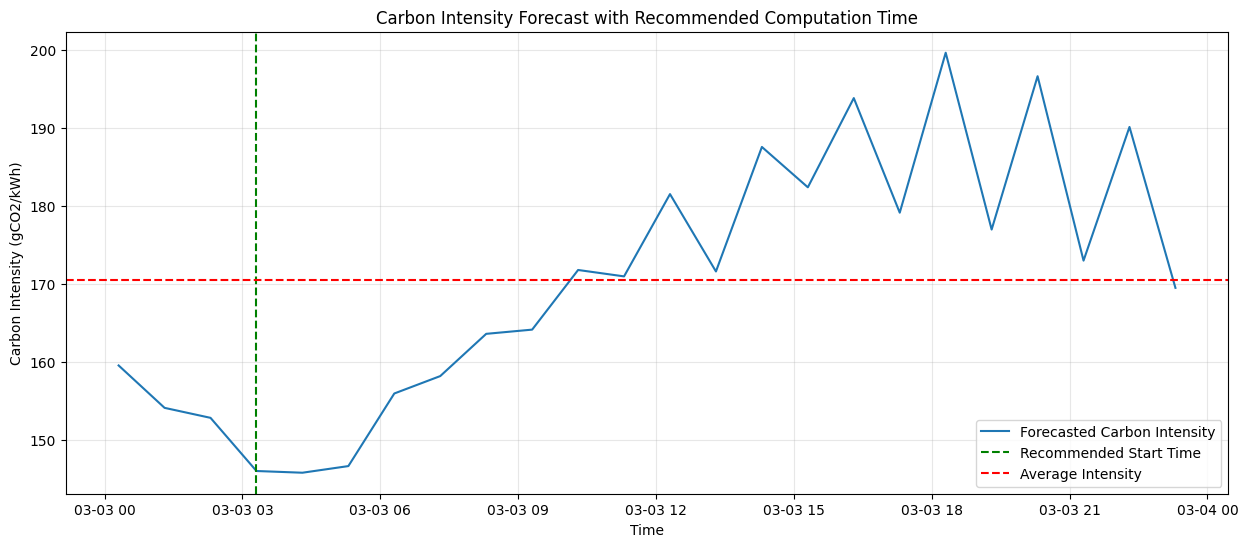

In [41]:
# Example usage
recommendation = recommend_compute_time(
    model,
    df_features.iloc[-24:],
    computation_hours=3,
    business_hours_only=True
)

print("\nRecommendation Summary:")
print(f"Start time: {recommendation['recommended_start_time']}")
print(f"Expected carbon intensity: {recommendation['expected_carbon_intensity']:.2f} gCO2/kWh")
print(f"Potential carbon saving: {recommendation['potential_carbon_saving']:.2f} gCO2")

# Visualization of recommendation
plt.figure(figsize=(15, 6))
plt.plot(recommendation['forecast_data']['timestamp'],
         recommendation['forecast_data']['carbon_intensity'],
         label='Forecasted Carbon Intensity')
plt.axvline(x=recommendation['recommended_start_time'],
            color='g', linestyle='--',
            label='Recommended Start Time')
plt.axhline(y=recommendation['forecast_data']['carbon_intensity'].mean(),
            color='r', linestyle='--',
            label='Average Intensity')
plt.title('Carbon Intensity Forecast with Recommended Computation Time')
plt.xlabel('Time')
plt.ylabel('Carbon Intensity (gCO2/kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Finally...

In [42]:
import joblib

# Save the model and important metadata
model_package = {
    'model': model,
    'features': features,
    'last_training_date': df_features.index[-1],
    'feature_importance': importance.to_dict(),
    'metrics': {
        'mae': mae,
        'rmse': rmse
    }
}

joblib.dump(model_package, 'carbon_intensity_predictor.joblib')

['carbon_intensity_predictor.joblib']